# Распознавание лиц

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

%matplotlib inline

In [2]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Датасет

Я взял часть открытого датасета [celebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html). В нем лежит ~24 000 выровненных фотографий 500 людей
- в `celebA_imgs` лежат сами картинки
- в `celebA_anno.txt` каждой картинке сопоставлен ее id
- в `celebA_train_split.txt` лежит разбиение датасета на train/val/test. Разбито в соотношении 0.71/0.16/0.13 со стратификацией


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!unzip -q gdrive/MyDrive/celebA_train_500.zip

replace celebA_train_500/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
!ls celebA_train_500

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


In [8]:
anno = {}
with open('celebA_train_500/celebA_anno.txt') as file:
    for line in file:
        key, value = line.split()
        anno[key] = int(value)

In [9]:
split = {}
with open('celebA_train_500/celebA_train_split.txt') as file:
    for line in file:
        key, value = line.split()
        split[key] = int(value)

In [10]:
train_labels = {}
val_labels = {}
test_labels = {}

root = 'celebA_train_500/celebA_imgs'
files = list(os.walk(os.path.join(root)))[0][2]

for file in files:
    if file in anno:
        if split[file] == 0:
            train_labels[file] = anno[file]
        if split[file] == 1:
            val_labels[file] = anno[file]
        if split[file] == 2:
            test_labels[file] = anno[file]

In [11]:
train_labels = pd.DataFrame(list(train_labels.items()), columns = ['img', 'label'])
val_labels   = pd.DataFrame(list(  val_labels.items()), columns = ['img', 'label'])
test_labels  = pd.DataFrame(list( test_labels.items()), columns = ['img', 'label'])
test_labels.head()

,img,label
0,157595.jpg,139
1,139105.jpg,134
2,161347.jpg,126
3,119392.jpg,380
4,129696.jpg,471


In [92]:
class FaceDataset(Dataset):
    def __init__(self, labels : pd.DataFrame, img_dir, transform=None):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = np.array(Image.open(img_path))
        img = Image.fromarray(img[77:-41, 45:-50])
        img_label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [93]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((170, 170)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [94]:
train_dataset = FaceDataset(train_labels, root, data_transform)
val_dataset   = FaceDataset(val_labels,   root, data_transform)
test_dataset  = FaceDataset(test_labels,  root, data_transform)

In [96]:
def plot_img(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')

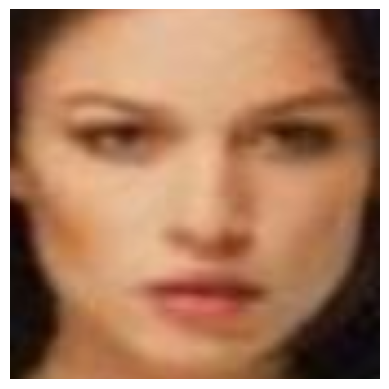

In [97]:
plot_img(test_dataset[0][0])

In [98]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)
loaders = {'train': train_loader, 'valid': val_loader}

## Модель

In [130]:
model = torchvision.models.resnet18(pretrained=True)

In [131]:
n_classes = 500
model.fc = nn.Linear(model.fc.in_features, n_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [132]:
frozen_layers = 1

for i, layer in enumerate(model.children()):
    if i < frozen_layers:
        for param in layer.parameters():
            param.requires_grad = False

In [133]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

In [134]:
def train_loop(model, criterion, optimizer, scheduler, loaders, num_epochs):
    epochs = []
    loss_history = {'train': [], 'valid': []}
    acc_history = {'train': [], 'valid': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')

        for stage, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            train_loss = 0
            val_loss = 0

            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if stage == 'train':
                    model.train()
                    optimizer.zero_grad()
                    output = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        output = model(x_batch)
                        val_loss = criterion(output, y_batch)

                preds = output.argmax(-1)
                correct = torch.sum(y_batch == preds)
                epoch_correct += correct.item()
                epoch_all += len(y_batch)

                if stage == 'train':
                    train_loss = criterion(output, y_batch)
                    train_loss.backward()
                    optimizer.step()

            loss_epoch = train_loss.item() if stage == 'train' else val_loss.item()
            acc_epoch = epoch_correct / epoch_all
            loss_history[stage].append(loss_epoch)
            acc_history[stage].append(acc_epoch)
            print(f'{stage} loss = {"%.5f" % loss_epoch}, accuracy = {"%.5f" % acc_epoch}')

        scheduler.step()
        epochs.append(epoch)

    return epochs, loss_history, acc_history

In [135]:
num_epochs = 10
epochs, loss, acc = train_loop(model, criterion, optimizer, scheduler, loaders, num_epochs)

Epoch 1
train loss = 5.28447, accuracy = 0.02470
valid loss = 4.71343, accuracy = 0.07668
Epoch 2
train loss = 3.04617, accuracy = 0.18715
valid loss = 3.76092, accuracy = 0.20501
Epoch 3
train loss = 2.38347, accuracy = 0.49146
valid loss = 2.09931, accuracy = 0.41321
Epoch 4
train loss = 1.22382, accuracy = 0.72940
valid loss = 1.80404, accuracy = 0.47977
Epoch 5
train loss = 0.54743, accuracy = 0.92580
valid loss = 1.34647, accuracy = 0.61928
Epoch 6
train loss = 0.15866, accuracy = 0.99368
valid loss = 0.84601, accuracy = 0.70181
Epoch 7
train loss = 0.03355, accuracy = 0.99906
valid loss = 0.71146, accuracy = 0.73855
Epoch 8
train loss = 0.02950, accuracy = 0.99977
valid loss = 0.71690, accuracy = 0.74494
Epoch 9
train loss = 0.02316, accuracy = 0.99988
valid loss = 0.71440, accuracy = 0.75559
Epoch 10
train loss = 0.01591, accuracy = 1.00000
valid loss = 0.74539, accuracy = 0.75346


In [138]:
def plot_history(epochs, loss, acc):
    fig, ax = plt.subplots(1, 2)

    ax[0].plot(epochs, loss['train'], label='train')
    ax[0].plot(epochs, loss['valid'], label='valid')
    ax[0].set_title('loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(epochs, acc['train'], label='train')
    ax[1].plot(epochs, acc['valid'], label='valid')
    ax[1].set_title('accuracy')
    ax[1].grid()
    ax[1].legend()

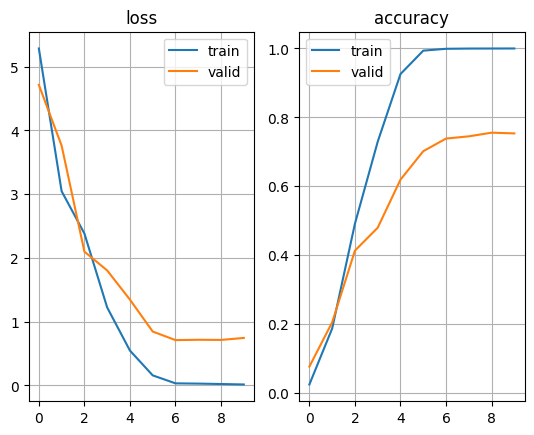

In [139]:
plot_history(epochs, loss, acc)

In [140]:
def test_accuracy(model, loader):
    all = 0
    correct = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        model.eval()
        output = model(x_batch)
        preds = output.argmax(-1)
        correct += torch.sum(y_batch == preds)
        all += len(y_batch)

    return correct / all

In [141]:
print(f'test accuracy = {test_accuracy(model, test_loader)}')

test accuracy = 0.7526746392250061
